# This notebook is code for accompanying article Estimating Time until Contract Termination — Survival Analysis with Lifelines

Article: https://towardsdatascience.com/estimating-time-until-contract-termination-survival-analysis-with-lifelines-212734cbca23?sk=b3ceba76135e8ce5bdf11c0cef248b75

Dataset:https://www.kaggle.com/HRAnalyticRepository/employee-attrition-data

In [1]:
df = pd.read_csv('MFG10YearTerminationData.csv')

$\hat{S}(t) = \prod_{t_i \lt t} \frac{n_i - d_i}{n_i}$

In [29]:
df[['length_of_service', 'STATUS']]

,length_of_service,STATUS
0,17,ACTIVE
1,18,ACTIVE
2,19,ACTIVE
3,20,ACTIVE
4,21,ACTIVE
...,...,...
49648,2,TERMINATED
49649,0,TERMINATED
49650,2,TERMINATED
49651,0,TERMINATED


In [5]:
df['Observed'] = df['STATUS'].apply(lambda x: 1 if x == 'TERMINATED' else 0)

# Kaplan-Meier Estimation

In [3]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

In [31]:
kmf.survival_function_.head()

,KM_estimate
timeline,
0.0,0.999376
1.0,0.996526
2.0,0.995824
3.0,0.995294
4.0,0.994662


In [7]:
kmf.fit(df['length_of_service'], df['Observed'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 49653 total observations, 48168 right-censored observations>

In [34]:
kmf.cumulative_density_

,KM_estimate
timeline,
0.0,0.000624
1.0,0.003474
2.0,0.004176
3.0,0.004706
4.0,0.005338


<AxesSubplot:title={'center':'Employee Contract Termination Survival Function'}, xlabel='timeline'>

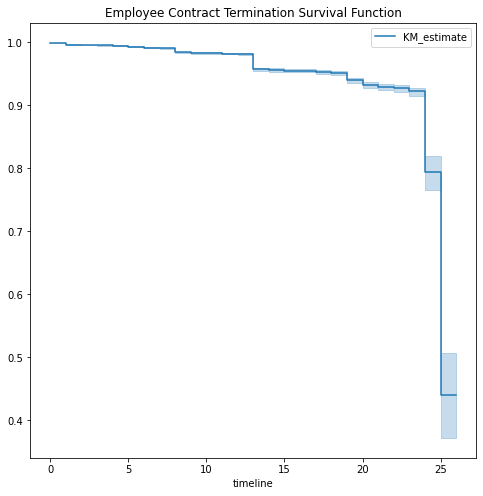

In [32]:
plt.figure(figsize = (8,8))
plt.title('Employee Contract Termination Survival Function')
kmf.plot_survival_function()

In [19]:
df_ho = df[df['BUSINESS_UNIT'] == 'HEADOFFICE']
df_s = df[df['BUSINESS_UNIT'] == 'STORES']

In [13]:
kmf_ho = KaplanMeierFitter()
kmf_s = KaplanMeierFitter()

In [22]:
kmf_ho.fit(df_ho['length_of_service'], df_ho['Observed'], label = 'HEADOFFICE')
kmf_s.fit(df_s['length_of_service'], df_s['Observed'], label = 'STORES')

<lifelines.KaplanMeierFitter:"STORES", fitted with 49068 total observations, 47652 right-censored observations>

<AxesSubplot:xlabel='timeline'>

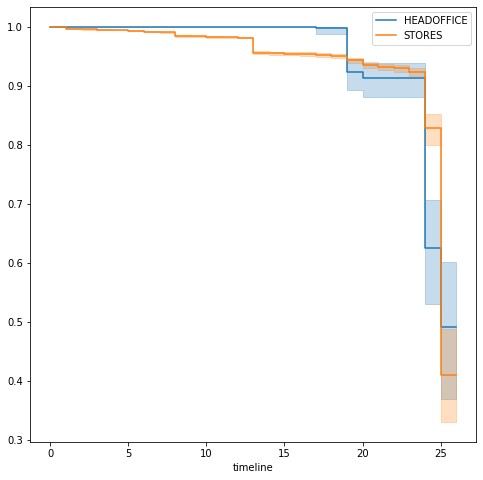

In [23]:
plt.figure(figsize = (8,8))
kmf_ho.plot_survival_function()
kmf_s.plot_survival_function()

In [25]:
df_m = df[df['gender_short'] == 'M']
df_f = df[df['gender_short'] == 'F']

In [26]:
kmf_m = KaplanMeierFitter()
kmf_f = KaplanMeierFitter()

In [27]:
kmf_m.fit(df_m['length_of_service'], df_m['Observed'], label = 'Male')
kmf_f.fit(df_f['length_of_service'], df_f['Observed'], label = 'Female')

<lifelines.KaplanMeierFitter:"Female", fitted with 25898 total observations, 24983 right-censored observations>

<AxesSubplot:title={'center':'Employee Contract Termination Survival Function based on Gender'}, xlabel='timeline'>

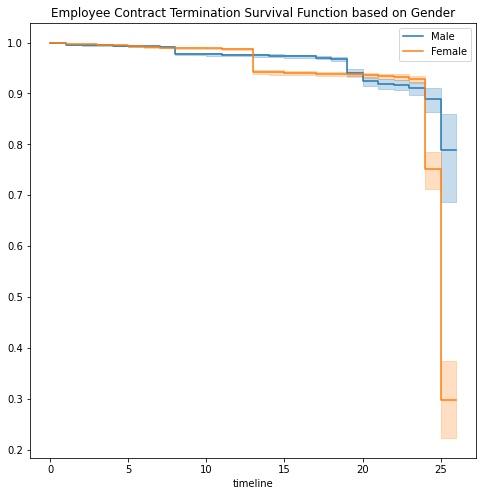

In [35]:
plt.figure(figsize = (8,8))
plt.title('Employee Contract Termination Survival Function based on Gender')
kmf_m.plot_survival_function()
kmf_f.plot_survival_function()

In [36]:
from lifelines.statistics import logrank_test

results = logrank_test(df_m['length_of_service'], df_f['length_of_service'], df_m['Observed'], df_f['Observed'], alpha=.95)
results.print_summary()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          24.03 <0.005     20.00

# Nelson-Aalen Estimation

In [37]:
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()

naf.fit(df['length_of_service'], df['Observed'])

<lifelines.NelsonAalenFitter:"NA_estimate", fitted with 49653 total observations, 48168 right-censored observations>

<AxesSubplot:title={'center':'Employee Contract Termination Hazard Function'}, xlabel='timeline'>

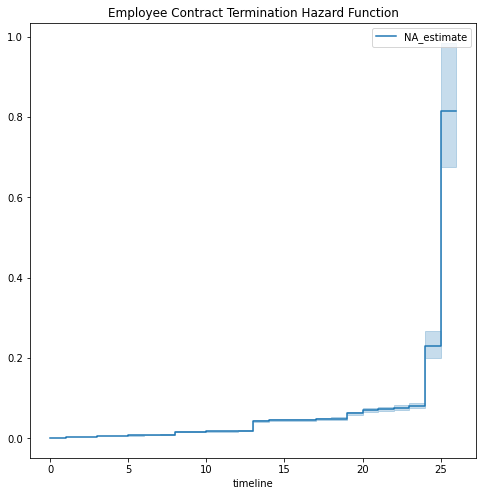

In [39]:
plt.figure(figsize = (8,8))
plt.title('Employee Contract Termination Hazard Function')
naf.plot_cumulative_hazard()

<AxesSubplot:>

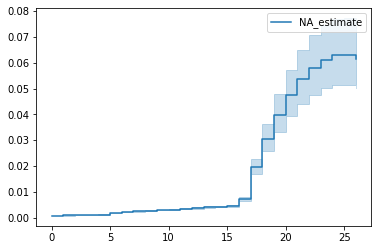

In [47]:
naf.plot_hazard(bandwidth = 9)

In [51]:
naf.cumulative_hazard_.head()

,NA_estimate
timeline,
0.0,0.000625
1.0,0.003480
2.0,0.004184
3.0,0.004717
4.0,0.005352


In [56]:
training = df[['age', 'gender_short', 'BUSINESS_UNIT', 'length_of_service','Observed']].copy()

In [58]:
training = pd.get_dummies(data = training, columns = ['gender_short', 'BUSINESS_UNIT'], drop_first = True)

In [59]:
training.head()

,age,length_of_service,Observed,gender_short_M,BUSINESS_UNIT_STORES
0,52,17,0,1,0
1,53,18,0,1,0
2,54,19,0,1,0
3,55,20,0,1,0
4,56,21,0,1,0


# Cox-Regression

In [60]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(training, duration_col='length_of_service', event_col='Observed')

<lifelines.CoxPHFitter: fitted with 49653 total observations, 48168 right-censored observations>

In [61]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 49653 total observations, 48168 right-censored observations>
             duration col = 'length_of_service'
                event col = 'Observed'
      baseline estimation = breslow
   number of observations = 49653
number of events observed = 1485
   partial log-likelihood = -14244.39
         time fit was run = 2021-02-07 14:36:05 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
age                   -0.01       0.99       0.00            -0.02            -0.01                 0.98                 0.99
gender_short_M        -0.30       0.74       0.05            -0.40            -0.19                 0.67                 0.83
BUSINESS_UNIT_STORES  -0.07       0.93       0.13            -0.32             0.18                 0.72                 1.20

                         z      p   -log2(p)
covariate                                   
age                  -3.46 <0.005      10.87
gender_short_M       -5.49 <0.005      24.59
BUSINESS_UNIT_STORES -0.55   0.58       0.78
---
Concordance = 0.59
Partial AIC = 28494.77
log-likelihood ratio test = 39.91 on 3 df
-log2(p) of ll-ratio test = 26.42

<AxesSubplot:>

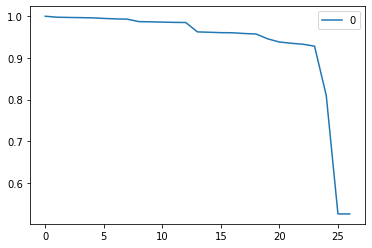

<AxesSubplot:>

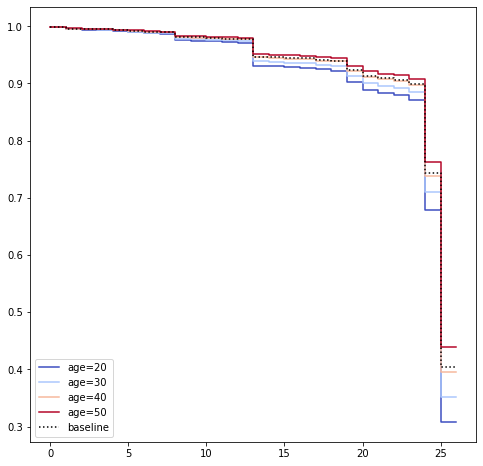

In [69]:
cph.plot_partial_effects_on_outcome(covariates='age', values=[20,30, 40, 50], cmap='coolwarm', figsize = (8,8))